<a href="https://colab.research.google.com/github/MihailMV/Fruits-and-vegetables/blob/master/NN_fruits_and_vegetables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import zipfile
import shutil
import numpy as np
from tqdm import tqdm

In [0]:
DIR = 'fruits_vegetables'
DIR_TRAIN = 'TRAIN'
DIR_VAL = 'VAL'
DIR_TEST = 'TEST'
IMG_SIZE = (224, 224)
MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])
BATCH_SIZE = 50

os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Colab Notebooks/kaggle/" 

In [4]:
!kaggle datasets download -d balalexv/fruits-vegetables-photos
with zipfile.ZipFile('/content/fruits-vegetables-photos.zip', 'r') as zip_obj:
   zip_obj.extractall('/content/')
!rm '/content/fruits-vegetables-photos.zip'

100% 1.79G/1.80G [00:20<00:00, 111MB/s]
100% 1.80G/1.80G [00:20<00:00, 94.6MB/s]


In [0]:
os.makedirs(os.path.join(DIR, DIR_VAL), exist_ok=True)
for class_name in os.listdir(os.path.join(DIR,DIR_TRAIN)):
  os.makedirs(os.path.join(DIR, DIR_VAL, class_name), exist_ok=True)
  for i, f in enumerate(os.listdir(os.path.join(DIR,DIR_TRAIN, class_name))):
    if (i % 5 == 0):
      shutil.move(os.path.join(DIR,DIR_TRAIN, class_name,f), os.path.join(DIR,DIR_VAL,class_name,f))

In [0]:
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
import torchvision
import torch
import matplotlib.pyplot as plt

In [0]:
train_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    #transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

val_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

train_dataset = torchvision.datasets.ImageFolder(os.path.join(DIR,DIR_TRAIN), train_transforms)
val_dataset = torchvision.datasets.ImageFolder(os.path.join(DIR,DIR_VAL), val_transforms)


In [0]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)


In [0]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = STD * image + MEAN
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)


In [0]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
  hist_loss_train = []
  hist_acc_train = []
  hist_loss_val = []
  hist_acc_val = []
  for epoch in range(num_epochs):
    # Train
    running_loss = 0.
    running_acc = 0.
    scheduler.step()
    model.train()
    for inputs, labels in tqdm(train_dataloader):
      inputs = inputs.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      with torch.set_grad_enabled(True):
        preds = model(inputs)
        loss_value = loss(preds, labels)
        preds_class = preds.argmax(dim=1)
        loss_value.backward()
        optimizer.step()
        running_loss += loss_value.item()
        running_acc += (preds_class == labels.data).float().mean()
        loss_train = running_loss / len(train_dataloader)
        acc_train = running_acc / len(train_dataloader)
        
    # Val
    running_loss = 0.
    running_acc = 0.
    model.eval()
    for inputs, labels in val_dataloader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      with torch.set_grad_enabled(False):
        preds = model(inputs)
        loss_value = loss(preds, labels)
        preds_class = preds.argmax(dim=1)
        running_loss += loss_value.item()
        running_acc += (preds_class == labels.data).float().mean()
        loss_val = running_loss / len(val_dataloader)
        acc_val = running_acc / len(val_dataloader)
    
    print(f'Epoch {epoch}/{num_epochs - 1}: Train: Loss: {loss_train:.4f}, Acc: {acc_train:.4f}   Val: Loss: {loss_val:.4f}, Acc: {acc_val:.4f}', flush=True)
    hist_loss_train.append(loss_train)
    hist_acc_train.append(acc_train.item())
    hist_loss_val.append(loss_val)
    hist_acc_val.append(acc_val.item())

  return model, [hist_loss_train,hist_acc_train,hist_loss_val,hist_acc_val]

In [0]:
model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, len(train_dataset.classes))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [28]:
model, hist = train_model(model, loss, optimizer, scheduler, num_epochs=30);

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
100%|██████████| 77/77 [00:35<00:00,  3.72it/s]


Epoch 0/29: Train: Loss: 1.2069, Acc: 0.7138   Val: Loss: 0.4850, Acc: 0.9297


100%|██████████| 77/77 [00:35<00:00,  3.92it/s]


Epoch 1/29: Train: Loss: 0.4060, Acc: 0.9235   Val: Loss: 0.2895, Acc: 0.9347


100%|██████████| 77/77 [00:35<00:00,  2.17it/s]


Epoch 2/29: Train: Loss: 0.2655, Acc: 0.9457   Val: Loss: 0.2265, Acc: 0.9477


100%|██████████| 77/77 [00:35<00:00,  2.19it/s]


Epoch 3/29: Train: Loss: 0.2006, Acc: 0.9582   Val: Loss: 0.1939, Acc: 0.9517


100%|██████████| 77/77 [00:35<00:00,  2.18it/s]


Epoch 4/29: Train: Loss: 0.1638, Acc: 0.9616   Val: Loss: 0.1588, Acc: 0.9597


100%|██████████| 77/77 [00:35<00:00,  2.20it/s]


Epoch 5/29: Train: Loss: 0.1460, Acc: 0.9655   Val: Loss: 0.1490, Acc: 0.9537


100%|██████████| 77/77 [00:35<00:00,  3.47it/s]


Epoch 6/29: Train: Loss: 0.1243, Acc: 0.9733   Val: Loss: 0.1353, Acc: 0.9607


100%|██████████| 77/77 [00:35<00:00,  3.45it/s]


Epoch 7/29: Train: Loss: 0.1221, Acc: 0.9743   Val: Loss: 0.1356, Acc: 0.9617


100%|██████████| 77/77 [00:35<00:00,  2.16it/s]


Epoch 8/29: Train: Loss: 0.1231, Acc: 0.9753   Val: Loss: 0.1369, Acc: 0.9617


100%|██████████| 77/77 [00:35<00:00,  2.16it/s]


Epoch 9/29: Train: Loss: 0.1163, Acc: 0.9764   Val: Loss: 0.1306, Acc: 0.9617


100%|██████████| 77/77 [00:35<00:00,  2.18it/s]


Epoch 10/29: Train: Loss: 0.1209, Acc: 0.9745   Val: Loss: 0.1368, Acc: 0.9587


100%|██████████| 77/77 [00:35<00:00,  4.05it/s]


Epoch 11/29: Train: Loss: 0.1134, Acc: 0.9756   Val: Loss: 0.1296, Acc: 0.9617


100%|██████████| 77/77 [00:35<00:00,  3.63it/s]


Epoch 12/29: Train: Loss: 0.1134, Acc: 0.9774   Val: Loss: 0.1301, Acc: 0.9657


100%|██████████| 77/77 [00:35<00:00,  3.68it/s]


Epoch 13/29: Train: Loss: 0.1098, Acc: 0.9787   Val: Loss: 0.1266, Acc: 0.9647


100%|██████████| 77/77 [00:35<00:00,  2.16it/s]


Epoch 14/29: Train: Loss: 0.1140, Acc: 0.9777   Val: Loss: 0.1295, Acc: 0.9647


100%|██████████| 77/77 [00:35<00:00,  3.56it/s]


Epoch 15/29: Train: Loss: 0.1076, Acc: 0.9800   Val: Loss: 0.1296, Acc: 0.9647


100%|██████████| 77/77 [00:35<00:00,  2.15it/s]


Epoch 16/29: Train: Loss: 0.1075, Acc: 0.9792   Val: Loss: 0.1295, Acc: 0.9637


100%|██████████| 77/77 [00:35<00:00,  2.16it/s]


Epoch 17/29: Train: Loss: 0.1089, Acc: 0.9774   Val: Loss: 0.1283, Acc: 0.9607


100%|██████████| 77/77 [00:35<00:00,  2.16it/s]


Epoch 18/29: Train: Loss: 0.1125, Acc: 0.9782   Val: Loss: 0.1264, Acc: 0.9637


100%|██████████| 77/77 [00:35<00:00,  2.16it/s]


Epoch 19/29: Train: Loss: 0.1068, Acc: 0.9816   Val: Loss: 0.1263, Acc: 0.9637


100%|██████████| 77/77 [00:35<00:00,  2.15it/s]


Epoch 20/29: Train: Loss: 0.1091, Acc: 0.9787   Val: Loss: 0.1276, Acc: 0.9637


100%|██████████| 77/77 [00:35<00:00,  3.78it/s]


Epoch 21/29: Train: Loss: 0.1132, Acc: 0.9761   Val: Loss: 0.1278, Acc: 0.9597


100%|██████████| 77/77 [00:36<00:00,  2.14it/s]


Epoch 22/29: Train: Loss: 0.1070, Acc: 0.9800   Val: Loss: 0.1281, Acc: 0.9637


100%|██████████| 77/77 [00:35<00:00,  4.01it/s]


Epoch 23/29: Train: Loss: 0.1119, Acc: 0.9796   Val: Loss: 0.1274, Acc: 0.9617


100%|██████████| 77/77 [00:35<00:00,  3.73it/s]


Epoch 24/29: Train: Loss: 0.1072, Acc: 0.9826   Val: Loss: 0.1278, Acc: 0.9627


100%|██████████| 77/77 [00:35<00:00,  2.15it/s]


Epoch 25/29: Train: Loss: 0.1100, Acc: 0.9803   Val: Loss: 0.1273, Acc: 0.9607


100%|██████████| 77/77 [00:35<00:00,  2.16it/s]


Epoch 26/29: Train: Loss: 0.1125, Acc: 0.9766   Val: Loss: 0.1282, Acc: 0.9597


100%|██████████| 77/77 [00:35<00:00,  2.15it/s]


Epoch 27/29: Train: Loss: 0.1098, Acc: 0.9800   Val: Loss: 0.1268, Acc: 0.9647


100%|██████████| 77/77 [00:35<00:00,  3.60it/s]


Epoch 28/29: Train: Loss: 0.1098, Acc: 0.9774   Val: Loss: 0.1274, Acc: 0.9637


100%|██████████| 77/77 [00:35<00:00,  2.15it/s]


Epoch 29/29: Train: Loss: 0.1100, Acc: 0.9777   Val: Loss: 0.1293, Acc: 0.9627


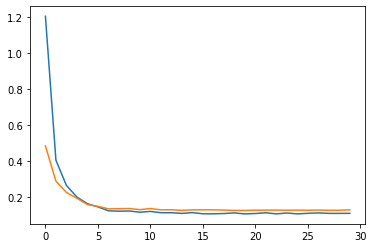

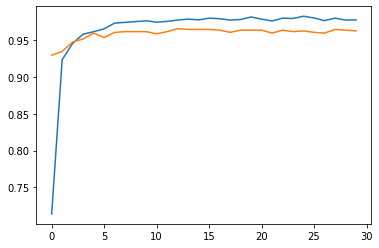

In [29]:
plt.plot(hist[0])
plt.plot(hist[2])
plt.show()

plt.plot(hist[1])
plt.plot(hist[3])
plt.show()


In [0]:
test_dataset = torchvision.datasets.ImageFolder(os.path.join(DIR,DIR_TEST), val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)

In [31]:
test_dataset

Dataset ImageFolder
    Number of datapoints: 117
    Root location: fruits_vegetables/TEST
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485 0.456 0.406], std=[0.229 0.224 0.225])
           )

In [32]:
model.eval()

test_predictions = []
test_img_paths = []

running_loss = 0.
running_acc = 0.

for inputs, labels in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
        preds_class = preds.argmax(dim=1)
        running_acc += (preds_class == labels.data).float().sum().cpu()


100%|██████████| 3/3 [00:01<00:00,  1.02it/s]


In [33]:
running_acc / 117, 117 - running_acc

(tensor(0.8034), tensor(23.))

In [26]:
running_acc / 117, 117 - running_acc

(tensor(0.7863), tensor(25.))

In [25]:
(117-9)/117

0.9230769230769231